# Banking_Prediction_fraudulent_model_ML - Santhosh Krishna R

In [2]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler



import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ydata_profiling as pf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("loan_data.csv")

In [4]:
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


### Data Cleaning and Advanced Feature Engineering

In [5]:
#We are removing rhe purpose and changing it to boolean (multiple) columns

df1 = pd.get_dummies(data, columns = ['purpose'], drop_first = True)
df1.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,False,True,False,False,False,False
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,True,False,False,False,False,False
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,False,True,False,False,False,False
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,False,True,False,False,False,False
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,True,False,False,False,False,False


In [6]:
#We are changing the boolean values to binary (0 or 1)

df1['purpose_credit_card'] = df1['purpose_credit_card'].astype(int)
df1['purpose_debt_consolidation'] = df1['purpose_debt_consolidation'].astype(int)
df1['purpose_educational'] = df1['purpose_educational'].astype(int)
df1['purpose_home_improvement'] = df1['purpose_home_improvement'].astype(int)
df1['purpose_major_purchase'] = df1['purpose_major_purchase'].astype(int)
df1['purpose_small_business'] = df1['purpose_small_business'].astype(int)
df1.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


In [7]:
#Advanced Feature Engineering. Where we add other columsn to get make a more accurate model

df1['credit.history.length'] = df1['days.with.cr.line'] / 365
df1['revol.bal.util'] = df1['revol.bal'] / (df1['revol.util'] * 100)
df1['income.installment.ratio'] = np.exp(df1['log.annual.inc']) / df1['installment']
df1['dti.adjusted'] = df1['dti'] * np.exp(df1['log.annual.inc'])
df1['recent.inquiry.rate'] = df1['inq.last.6mths'] / 6
df1['delinq.rate'] = df1['delinq.2yrs'] / 2
df1['fico.int.rate.interaction'] = df1['fico'] * df1['int.rate']
df1['dti.int.rate.interaction'] = df1['dti'] * df1['int.rate']
df1['credit.line.income.interaction'] = df1['credit.history.length'] * np.exp(df1['log.annual.inc'])


In [8]:
df1.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,...,purpose_small_business,credit.history.length,revol.bal.util,income.installment.ratio,dti.adjusted,recent.inquiry.rate,delinq.rate,fico.int.rate.interaction,dti.int.rate.interaction,credit.line.income.interaction
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,...,0,15.451941,5.538196,102.520806,1.655800e+06,0.000000,0.0,87.6293,2.316172,1.313415e+06
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,...,0,7.561644,4.383703,284.812900,9.288500e+05,0.000000,0.0,75.7197,1.530459,4.915068e+05
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,...,0,12.904110,1.371484,87.226735,3.721600e+05,0.166667,0.0,92.5474,1.578191,4.129315e+05
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,...,0,7.397146,4.599317,523.592463,6.885000e+05,0.166667,0.0,71.7696,0.816480,6.287574e+05
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,...,0,11.139726,1.200000,785.075783,1.209576e+06,0.000000,0.5,95.1142,2.134722,9.000899e+05


In [9]:
df1.columns

Index(['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_small_business',
       'credit.history.length', 'revol.bal.util', 'income.installment.ratio',
       'dti.adjusted', 'recent.inquiry.rate', 'delinq.rate',
       'fico.int.rate.interaction', 'dti.int.rate.interaction',
       'credit.line.income.interaction'],
      dtype='object')

In [10]:
#We are checking if the new table has any infinite values (It initially had 43 infinite values in revol.bal.util)

print(np.isinf(df1[['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_small_business',
       'credit.history.length', 'revol.bal.util', 'income.installment.ratio',
       'dti.adjusted', 'recent.inquiry.rate', 'delinq.rate',
       'fico.int.rate.interaction', 'dti.int.rate.interaction',
       'credit.line.income.interaction']]).sum())

credit.policy                      0
int.rate                           0
installment                        0
log.annual.inc                     0
dti                                0
fico                               0
days.with.cr.line                  0
revol.bal                          0
revol.util                         0
inq.last.6mths                     0
delinq.2yrs                        0
pub.rec                            0
not.fully.paid                     0
purpose_credit_card                0
purpose_debt_consolidation         0
purpose_educational                0
purpose_home_improvement           0
purpose_major_purchase             0
purpose_small_business             0
credit.history.length              0
revol.bal.util                    43
income.installment.ratio           0
dti.adjusted                       0
recent.inquiry.rate                0
delinq.rate                        0
fico.int.rate.interaction          0
dti.int.rate.interaction           0
c

In [11]:
#We are checking if the table has any NA values

print(np.isinf(df1[['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_small_business',
       'credit.history.length', 'revol.bal.util', 'income.installment.ratio',
       'dti.adjusted', 'recent.inquiry.rate', 'delinq.rate',
       'fico.int.rate.interaction', 'dti.int.rate.interaction',
       'credit.line.income.interaction']]).isna().sum())

credit.policy                     0
int.rate                          0
installment                       0
log.annual.inc                    0
dti                               0
fico                              0
days.with.cr.line                 0
revol.bal                         0
revol.util                        0
inq.last.6mths                    0
delinq.2yrs                       0
pub.rec                           0
not.fully.paid                    0
purpose_credit_card               0
purpose_debt_consolidation        0
purpose_educational               0
purpose_home_improvement          0
purpose_major_purchase            0
purpose_small_business            0
credit.history.length             0
revol.bal.util                    0
income.installment.ratio          0
dti.adjusted                      0
recent.inquiry.rate               0
delinq.rate                       0
fico.int.rate.interaction         0
dti.int.rate.interaction          0
credit.line.income.interacti

In [12]:
# Replace inf and -inf with NaN
df1['revol.bal.util'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median of the column
median_revol_bal_util = df1['revol.bal.util'].median()
df1['revol.bal.util'].fillna(median_revol_bal_util, inplace=True)


In [13]:
#Split the dataset

X = df1[['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_small_business',
       'credit.history.length', 'revol.bal.util', 'income.installment.ratio',
       'dti.adjusted', 'recent.inquiry.rate', 'delinq.rate',
       'fico.int.rate.interaction', 'dti.int.rate.interaction',
       'credit.line.income.interaction']]
y = df1['not.fully.paid']



In [41]:
# Normalize features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### VAE Implementation - To add synthetic features

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [43]:
# Define the VAE model
input_dim = X.shape[1]
latent_dim = 2

inputs = Input(shape=(input_dim,))
h = Dense(16, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


In [44]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [45]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(inputs, z_mean)

In [46]:
decoder_h = Dense(16, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


In [47]:
#Model
vae = Model(inputs, x_decoded_mean)

In [48]:
# Define VAE loss
xent_loss = input_dim * binary_crossentropy(inputs, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

In [49]:
# Train the VAE
vae.fit(X_scaled, X_scaled, epochs=100, batch_size=32)

Epoch 1/100
300/300 [==============================] - 3s 4ms/step - loss: 4.2701
Epoch 2/100
300/300 [==============================] - 1s 5ms/step - loss: -174.3825
Epoch 3/100
300/300 [==============================] - 1s 5ms/step - loss: -1227.3140
Epoch 4/100
300/300 [==============================] - 1s 5ms/step - loss: -4476.0083
Epoch 5/100
300/300 [==============================] - 1s 5ms/step - loss: -11799.3896
Epoch 6/100
300/300 [==============================] - 1s 5ms/step - loss: -25765.1895
Epoch 7/100
300/300 [==============================] - 1s 5ms/step - loss: -50263.8047
Epoch 8/100
300/300 [==============================] - 1s 5ms/step - loss: -88221.9297
Epoch 9/100
300/300 [==============================] - 1s 5ms/step - loss: -146136.5156
Epoch 10/100
300/300 [==============================] - 1s 5ms/step - loss: -227125.9219
Epoch 11/100
300/300 [==============================] - 1s 4ms/step - loss: -339102.9062
Epoch 12/100
300/300 [=========================

300/300 [==============================] - 1s 4ms/step - loss: -1755166848.0000
Epoch 92/100
300/300 [==============================] - 1s 5ms/step - loss: -1830310016.0000
Epoch 93/100
300/300 [==============================] - 1s 4ms/step - loss: -1913611008.0000
Epoch 94/100
300/300 [==============================] - 1s 4ms/step - loss: -1923631232.0000
Epoch 95/100
300/300 [==============================] - 1s 5ms/step - loss: -2078884992.0000
Epoch 96/100
300/300 [==============================] - 1s 4ms/step - loss: -2167203840.0000
Epoch 97/100
300/300 [==============================] - 1s 4ms/step - loss: -1804830208.0000
Epoch 98/100
300/300 [==============================] - 1s 5ms/step - loss: -2330828032.0000
Epoch 99/100
300/300 [==============================] - 1s 5ms/step - loss: -2437945856.0000
Epoch 100/100
300/300 [==============================] - 1s 4ms/step - loss: -2549538816.0000


In [50]:
#Including the synthetic feature to the table

synthetic_features = encoder.predict(X_scaled)
df1['synthetic_feature_1'] = synthetic_features[:, 0]
df1['synthetic_feature_2'] = synthetic_features[:, 1]



300/300 [==============================] - 1s 3ms/step


In [51]:
df1.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,...,dti.adjusted,recent.inquiry.rate,delinq.rate,fico.int.rate.interaction,dti.int.rate.interaction,credit.line.income.interaction,synthetic_feature_1,synthetic_feature_2,gan_synthetic_feature_1,gan_synthetic_feature_2
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,...,1.655800e+06,0.000000,0.0,87.6293,2.316172,1.313415e+06,-1244.959106,-1263.936523,0.574077,0.477476
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,...,9.288500e+05,0.000000,0.0,75.7197,1.530459,4.915068e+05,25107.789062,25242.910156,0.568513,0.495529
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,...,3.721600e+05,0.166667,0.0,92.5474,1.578191,4.129315e+05,20501.427734,20609.968750,0.488464,0.451122
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,...,6.885000e+05,0.166667,0.0,71.7696,0.816480,6.287574e+05,33903.777344,34085.644531,0.480134,0.467005
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,...,1.209576e+06,0.000000,0.5,95.1142,2.134722,9.000899e+05,-342.769135,-341.086426,0.448881,0.440276


### GAN Implementation - To add extra synthetic features

In [52]:
# Define the GAN model components
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(16, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(input_dim, activation='sigmoid'))
    return model

def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(16, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [53]:
latent_dim = 2
generator = build_generator(latent_dim)
discriminator = build_discriminator(input_dim)
discriminator.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
# Define GAN
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)


In [55]:
#model

gan = Model(z, valid)
gan.compile(optimizer=Adam(), loss='binary_crossentropy')

In [56]:
def train_gan(gan, generator, discriminator, X_train, epochs, batch_size):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.array([1] * batch_size)
        g_loss = gan.train_on_batch(noise, valid_y)

        if epoch % 1000 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

In [57]:
# Train the GAN
train_gan(gan, generator, discriminator, X_scaled, epochs=100, batch_size=32)

1/1 [==============================] - 0s 143ms/step
0 [D loss: 0.6226146519184113, acc.: 71.875] [G loss: 0.8157966136932373]
1/1 [==============================] - 0s 62ms/step


In [58]:
# Generate synthetic features
noise = np.random.normal(0, 1, (X_scaled.shape[0], latent_dim))
synthetic_features_gan = generator.predict(noise)
df1['gan_synthetic_feature_1'] = synthetic_features_gan[:, 0]
df1['gan_synthetic_feature_2'] = synthetic_features_gan[:, 1]


300/300 [==============================] - 1s 3ms/step


In [59]:
# Add synthetic features to the dataset
X_with_synthetic = np.hstack((X_scaled, synthetic_features, synthetic_features_gan))


In [60]:
df1.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,...,dti.adjusted,recent.inquiry.rate,delinq.rate,fico.int.rate.interaction,dti.int.rate.interaction,credit.line.income.interaction,synthetic_feature_1,synthetic_feature_2,gan_synthetic_feature_1,gan_synthetic_feature_2
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,...,1.655800e+06,0.000000,0.0,87.6293,2.316172,1.313415e+06,-1244.959106,-1263.936523,0.588828,0.499234
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,...,9.288500e+05,0.000000,0.0,75.7197,1.530459,4.915068e+05,25107.789062,25242.910156,0.599408,0.484759
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,...,3.721600e+05,0.166667,0.0,92.5474,1.578191,4.129315e+05,20501.427734,20609.968750,0.485674,0.562060
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,...,6.885000e+05,0.166667,0.0,71.7696,0.816480,6.287574e+05,33903.777344,34085.644531,0.564929,0.509773
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,...,1.209576e+06,0.000000,0.5,95.1142,2.134722,9.000899e+05,-342.769135,-341.086426,0.663201,0.426103


### Splitting the data

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_with_synthetic, y, test_size=0.2, random_state=42)


### SMOTE Implemtation

In [62]:
from imblearn.over_sampling import SMOTE


In [63]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

Best Threshold: 0.86
Best Precision: 1.00
Best F1 Score: 0.02
Best Accuracy: 0.84
Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1611
           1       1.00      0.01      0.02       305

    accuracy                           0.84      1916
   macro avg       0.92      0.50      0.47      1916
weighted avg       0.87      0.84      0.77      1916



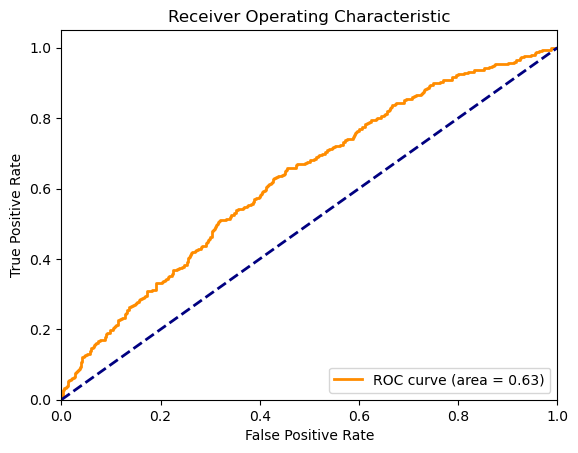

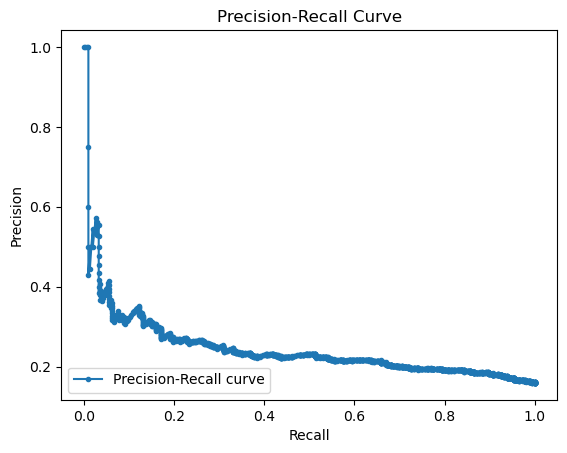

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, f1_score, accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


# Train a new model on the resampled dataset using XGBoost
clf_resampled = XGBClassifier(random_state=42, n_estimators=150)
clf_resampled.fit(X_resampled, y_resampled)

# Get predicted probabilities on the test set
y_proba_resampled = clf_resampled.predict_proba(X_test)[:, 1]

# Define a range of thresholds
thresholds = np.arange(0.0, 1.0, 0.001)
precision_scores = []
f1_scores = []
accuracy_scores = []

# Calculate precision, accuracy, and f1 score for each threshold
for threshold in thresholds:
    y_pred_threshold = (y_proba_resampled >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    accuracy = accuracy_score(y_test, y_pred_threshold)
    
    precision_scores.append(precision)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Find the threshold that balances F1, precision, and accuracy
best_index = np.argmax(np.array(f1_scores) + np.array(precision_scores) + np.array(accuracy_scores))
best_threshold = thresholds[best_index]
best_precision = precision_scores[best_index]
best_f1_score = f1_scores[best_index]
best_accuracy = accuracy_scores[best_index]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best Precision: {best_precision:.2f}")
print(f"Best F1 Score: {best_f1_score:.2f}")
print(f"BestAccuracy: {best_accuracy:.2f}")

# Generate the classification report with the best threshold
y_pred_best_threshold = (y_proba_resampled >= best_threshold).astype(int)
print("Classification Report with Best Threshold:")
print(classification_report(y_test, y_pred_best_threshold))

# Calculate and plot ROC Curve
roc_auc = roc_auc_score(y_test, y_proba_resampled)
fpr, tpr, _ = roc_curve(y_test, y_proba_resampled)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_resampled)
plt.figure()
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
